# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pylab import rcParams
import seaborn as sns


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf



from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import(mean_squared_error,mean_absolute_error,r2_score)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, learning_curve



from xgboost import XGBRegressor
import shap

import warnings
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 10,8
plt.style.use('Solarize_Light2')

In [7]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [8]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [9]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [11]:
print(df.index.is_monotonic)

True


is_monotonic is to check if the dates and times are in chronological order, look at the is_monotonic attribute of the table index. If the order is chronological, the attribute will return True; if not, False

In [12]:
print(f'Our data is from {df.index.min()} to {df.index.max()}')

Our data is from 2018-03-01 00:00:00 to 2018-08-31 23:50:00


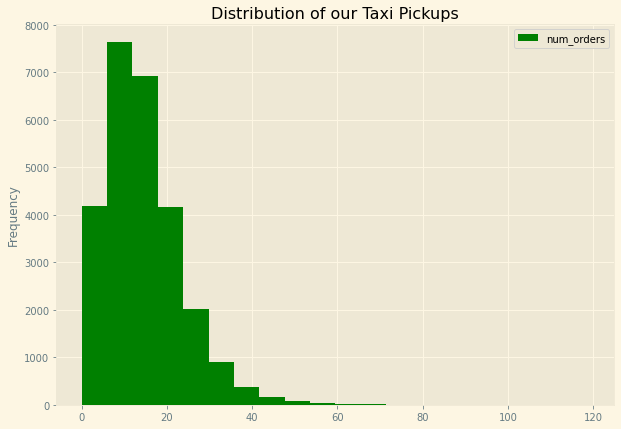

In [13]:
df.plot(kind ='hist',color = 'green',bins = 20, title = "Distribution of our Taxi Pickups", figsize = (10,7))
plt.show()

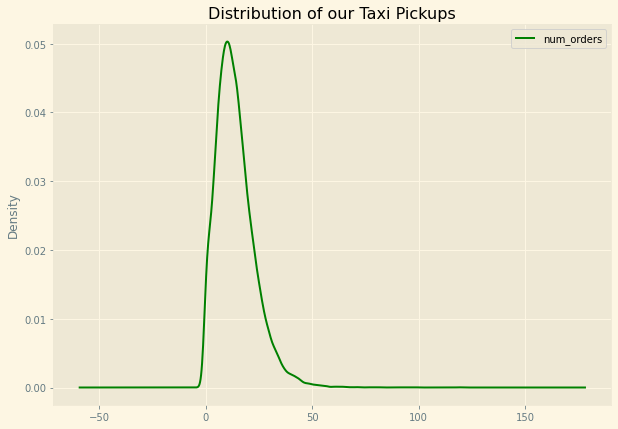

In [14]:
df.plot(kind ='kde',color = 'green', title = "Distribution of our Taxi Pickups", figsize = (10,7), grid = True)
plt.show()

We Can see most of values are centered around 0 - 60 taxi pickups 

In [15]:
df = df.resample("1H").sum()


I resample the data by the mean of every hour. We can see that daily pickups are increasing over the period

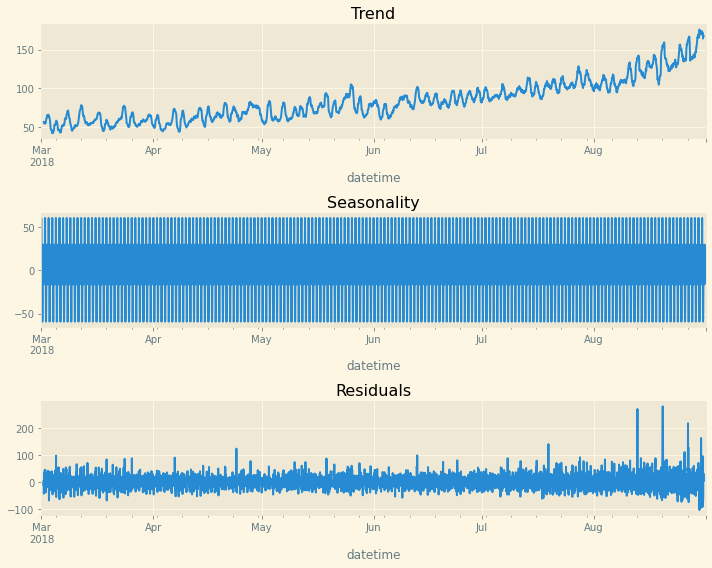

In [16]:
plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed = seasonal_decompose(df)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

The trend component is supposed to capture the slowly-moving overall level of the series.
The seasonal component captures patterns that repeat every season.
The residual is what is left. It may or may not be autocorrelated.  We can see the trend is up and in residuals we get some large spikes towards the end. 


In [17]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


 Lag plots are used to check if a time series is random.

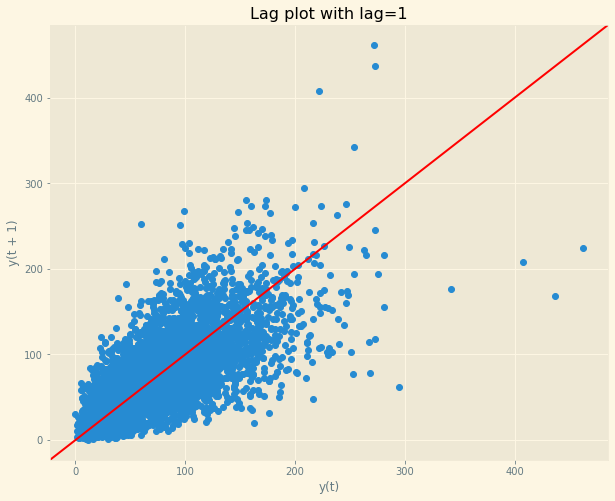

In [18]:
lag_plot(df,lag=1)
plt.title("Lag plot with lag=1")
plt.axline((1, 1), slope=1, color = 'Red')

the data exhibits high auto correlation behaviour as the points in the lag plot lie around the diagonal line.

Autocorrelation is the correlation between a time series’ current value with past values.
Positive autocorrelation means that a high value now is likely to yield a high value in the future and vice versa

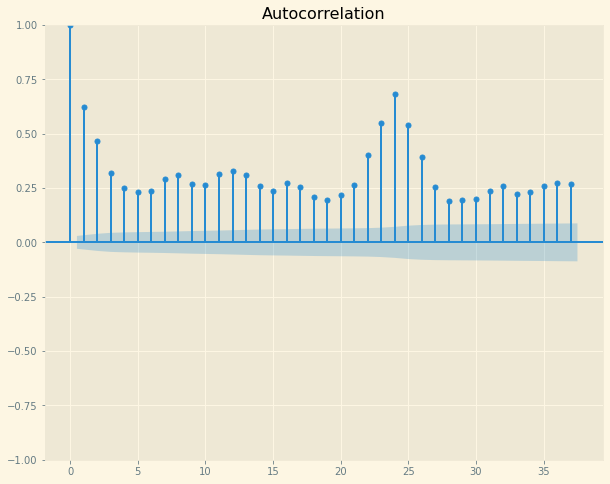

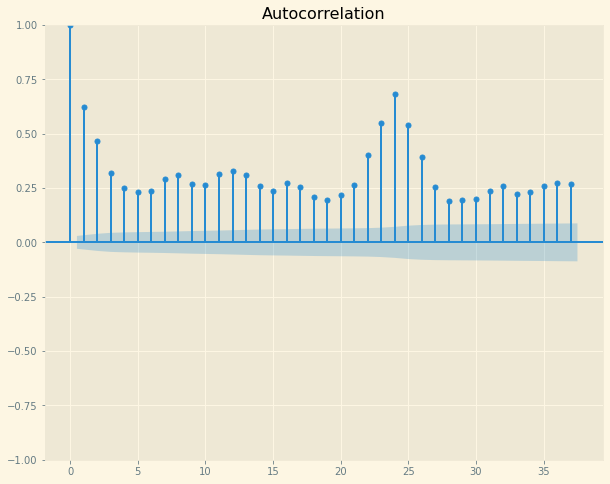

In [19]:
plot_acf(df)

As the lags increase we can see still there is a strong correlation

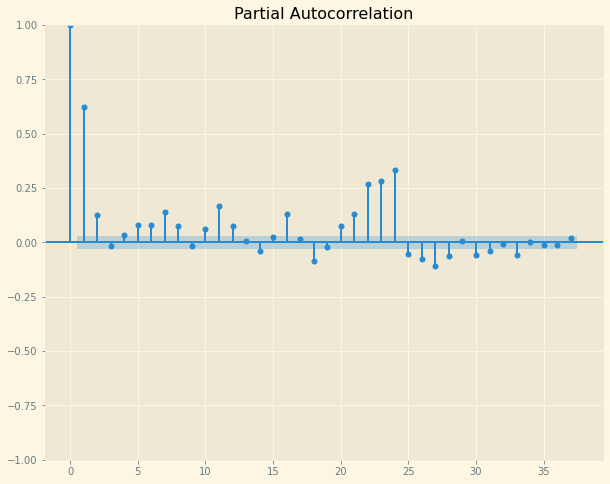

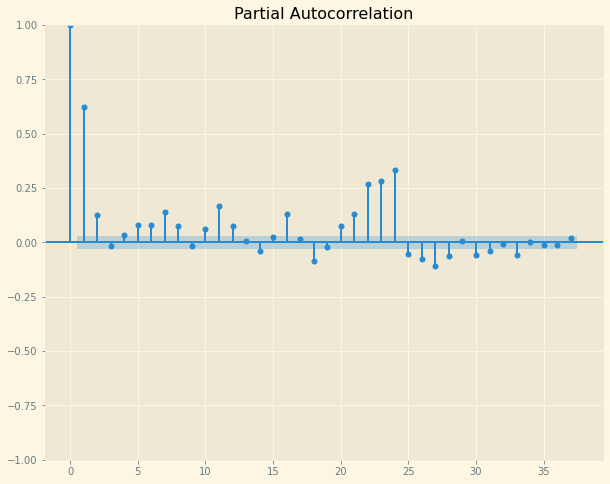

In [16]:
plot_pacf(df)

The PACF is an alternative to the ACF. Rather than giving the autocorrelations, it gives you the partial autocorrelation. This autocorrelation is called partial, because with each step back in the past, only additional autocorrelation is listed. This is different from the ACF, as the ACF contains duplicate correlations when variability can be explained by multiple points in time, There is a strong positive autocorrelation with lag 1-2: a high value now means that you are very likely to observe a high value in the next step. Since the autocorrelation shown here is partial, you do not see any duplicate effects with earlier lags, making the PACF plot neater and clearer.

# Importing Features

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(4).mean()
make_features(df,5,5)

df.dropna(inplace = True)

We make new features from our data column using year,month,day and day of week,hour. I also used the lag method which is The previous values in the time series it  will tell you whether the function x(t) will grow or decrease. I droped all the na values as well

In [21]:
df.head()

,num_orders,year,month,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 05:00:00,6,2018,3,3,5,43.0,66.0,71.0,85.0,124.0,66.25
2018-03-01 06:00:00,12,2018,3,3,6,6.0,43.0,66.0,71.0,85.0,46.50
2018-03-01 07:00:00,15,2018,3,3,7,12.0,6.0,43.0,66.0,71.0,31.75
2018-03-01 08:00:00,34,2018,3,3,8,15.0,12.0,6.0,43.0,66.0,19.00
2018-03-01 09:00:00,69,2018,3,3,9,34.0,15.0,12.0,6.0,43.0,16.75


<AxesSubplot:>

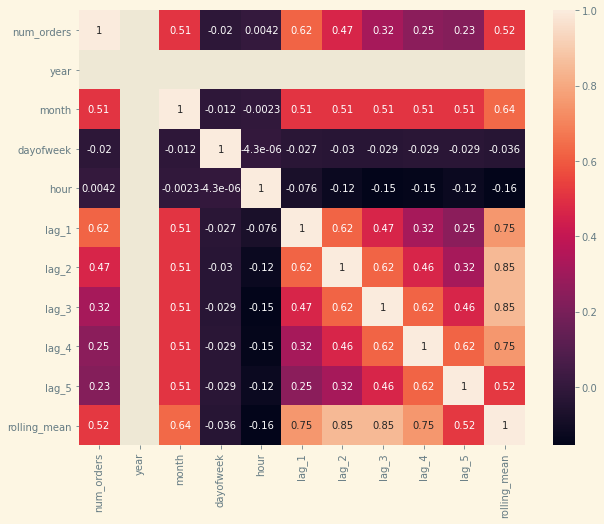

In [22]:
sns.heatmap(df.corr(), annot = True)

<AxesSubplot:>

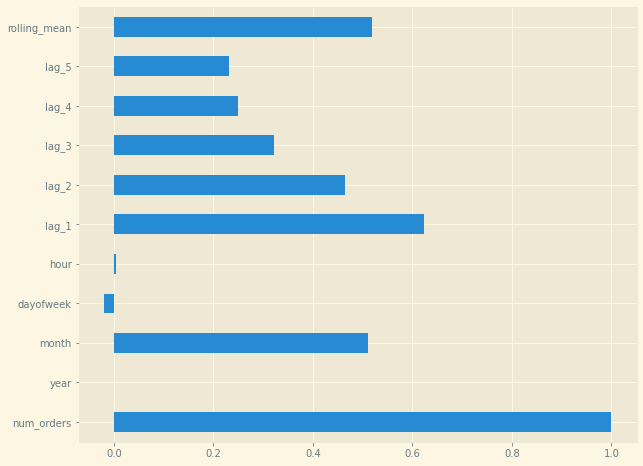

In [20]:
corr= df.corr()
corr['num_orders'].plot(kind = 'barh')

We can see some of lag values are highly correlated to our num_orders columns and also month is correlated to our num_orders column. 

# Model training 

In [23]:
train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state =123)
X_train, y_train = train.iloc[:,1:] , train.iloc[:,0]
X_test, y_test = test.iloc[:,1:] , test.iloc[:,0]

tscv = TimeSeriesSplit(n_splits=5)

In [22]:

rf = Pipeline([('scale2',StandardScaler()),("RF", RandomForestRegressor(random_state = 123))])
xb = Pipeline([('scale3',StandardScaler()),("XGR",XGBRegressor(random_state = 123))])

In [23]:
rf_model = cross_val_score(rf, X_train,  y_train, cv=tscv, scoring = 'neg_root_mean_squared_error')

In [24]:
xb_model = cross_val_score(xb, X_train,  y_train, cv=tscv, scoring = 'neg_root_mean_squared_error')

Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit

In [25]:
dataframe = {"Random Forest":rf_model.mean()*-1,'XGboost':xb_model.mean()*-1}
scores = pd.DataFrame(dataframe, index = [0])
scores

,Random Forest,XGboost
0,25.302425,26.499465


We can see that our RMSE are in 25,26 from our actual values which is good. Since our directions were to stay below 48 

In [26]:
xb.fit(X_train,y_train)
y_pred = xb.predict(X_test)

xb_data = pd.DataFrame({'actual': y_test, 'pred':y_pred})

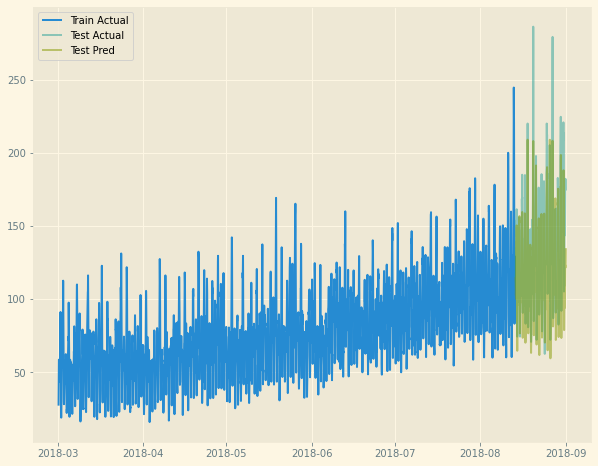

In [27]:
plt.plot(y_train.rolling(5).mean(), label = 'Train Actual',)
plt.plot(xb_data.actual.rolling(5).mean(), label = 'Test Actual',alpha=0.5)
plt.plot(xb_data.pred.rolling(5).mean(), label = 'Test Pred',alpha=0.5)
plt.legend()

We can see that our model didnt capture the full values towards the end of the year, maybe the data is sufficent to calcualte the increase num of orders. We would need year over year data to make a better prediction

In [28]:
# Here we access the XGBRegressor From our pipeline
XGBR = xb.steps[1][1]


In [29]:
explainer = shap.TreeExplainer(XGBR)
shap_values = explainer.shap_values(X_test)

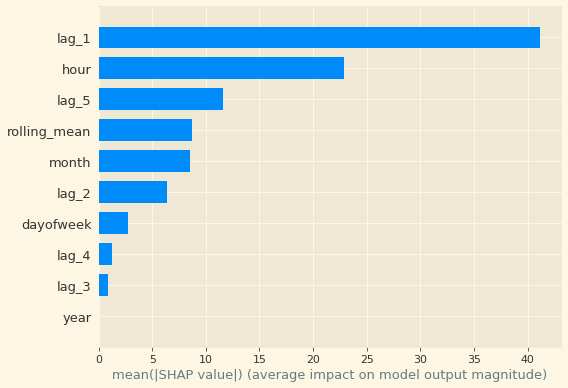

In [30]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Here we get our Feauture importance columns  we can see some of the top columns that had impact on our  XGB model

In [31]:
rf.fit(X_train,y_train)
rf.predict(X_test)
rf_data = pd.DataFrame({'actual': y_test, 'pred':y_pred})

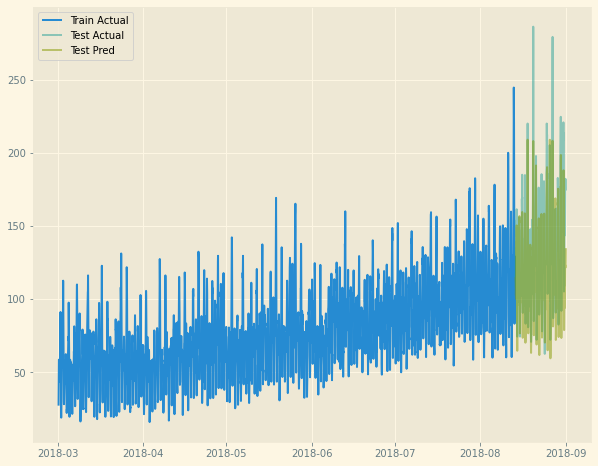

In [32]:
plt.plot(y_train.rolling(5).mean(), label = 'Train Actual',)
plt.plot(rf_data.actual.rolling(5).mean(), label = 'Test Actual',alpha=0.5)
plt.plot(rf_data.pred.rolling(5).mean(), label = 'Test Pred',alpha=0.5)
plt.legend()

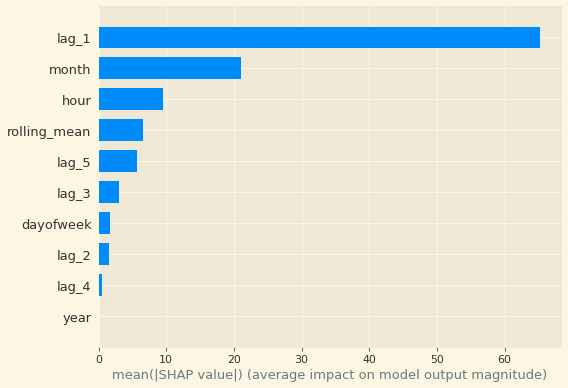

In [33]:
RF = rf.steps[1][1]
explainer = shap.TreeExplainer(RF)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

Here we get our Feauture importance columns  we can see some of the top columns that had impact on our  RF model

In [34]:
para = {'max_depth': [10, 20, 30, 40, 50,],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4,50],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [130, 180, 230]}

In [35]:
model= GridSearchCV(RF,para, scoring = 'neg_root_mean_squared_error', cv = tscv )
model.fit(X_train,y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=123),
             param_grid={'max_depth': [10, 20, 30, 40, 50],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4, 50],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [130, 180, 230]},
             scoring='neg_root_mean_squared_error')

In [36]:
print(model.best_params_)
print(model.best_score_*-1)



{'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 230}
25.27791277288765


In [37]:
rf = Pipeline([('scale2',StandardScaler()),("RF", RandomForestRegressor(random_state = 123, max_depth = 20, max_features= 'auto',
                                                                        min_samples_leaf= 1, min_samples_split = 10, n_estimators = 230))])

In [38]:
rf_model = cross_val_score(rf, X_test,  y_test, cv=tscv, scoring = 'neg_root_mean_squared_error')


In [40]:
print(rf_model)
print(rf_model.mean())

[-39.694778   -51.40132222 -34.67089285 -43.590265   -51.18842569]
-44.10913675159252


Here we tune our best model which you can see as the cross validate starts in the beginning the num_orders column is more stable  in the charts above and towards the end we get higher spikes making it harder for our model to predict those spikes. 

In [24]:
rf = Pipeline([('scale2',StandardScaler()),("RF", RandomForestRegressor(random_state = 123, max_depth = 20, max_features= 'auto',
                                                                        min_samples_leaf= 1, min_samples_split = 10, n_estimators = 230))])

In [25]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_test,y_pred))

In [27]:
print(RMSE)

46.73879708543337


# In Conslusion

Our task  was to predict the amount of taxi orders for the next hour.
We needed resample it by one hour. I used the Seasonal Decompe from statsmodel to see trend, seasonality and the residuals. I plotted the ACF .  ACF explains how the present value of a given time series is correlated with the past (1-unit past, 2-unit past, …, n-unit past) values. In the ACF plot, the y-axis expresses the correlation coefficient whereas the x-axis mentions the number of lags. the partial autocorrelation function (PACF) gives the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. We can see later in the year our values are descreasing meaning that they not correlated from our past values. I imported new features  using the date,rolling mean and lag method to get new columns. I trained 2 Model using Random Forest and XG Boost  cross validating them scoring  the neg root mean error. We used the libary shap to plot the feature importance of each column in both models . I used grid search to tune our best model which was Random Forest. Our objective was to find a score of RMSE below 48 our average score is 46.7